In [1]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:98% ! important; }<style>"))

# Importing libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importing Datasets

In [3]:
data = pd.read_csv(r"D:\AnalytixLabs\5. Machine Learning\Assignments\13. Electricity Demand Estimation\Electricity Consumption.csv", parse_dates=[0])
data.head()

,DATE,Electricty_Consumption_in_TW
0,1973-01-01,35.9728
1,1973-02-01,36.1334
2,1973-03-01,35.0625
3,1973-04-01,33.8416
4,1973-05-01,33.5107


In [4]:
data.columns = ['Date', 'Consumption']

In [5]:
data['Year'] = data.Date.dt.year
data['Month'] = data.Date.dt.month
data.head()

,Date,Consumption,Year,Month
0,1973-01-01,35.9728,1973,1
1,1973-02-01,36.1334,1973,2
2,1973-03-01,35.0625,1973,3
3,1973-04-01,33.8416,1973,4
4,1973-05-01,33.5107,1973,5


In [6]:
data.set_index('Date', inplace=True)
data.head()

,Consumption,Year,Month
Date,,,
1973-01-01,35.9728,1973,1
1973-02-01,36.1334,1973,2
1973-03-01,35.0625,1973,3
1973-04-01,33.8416,1973,4
1973-05-01,33.5107,1973,5


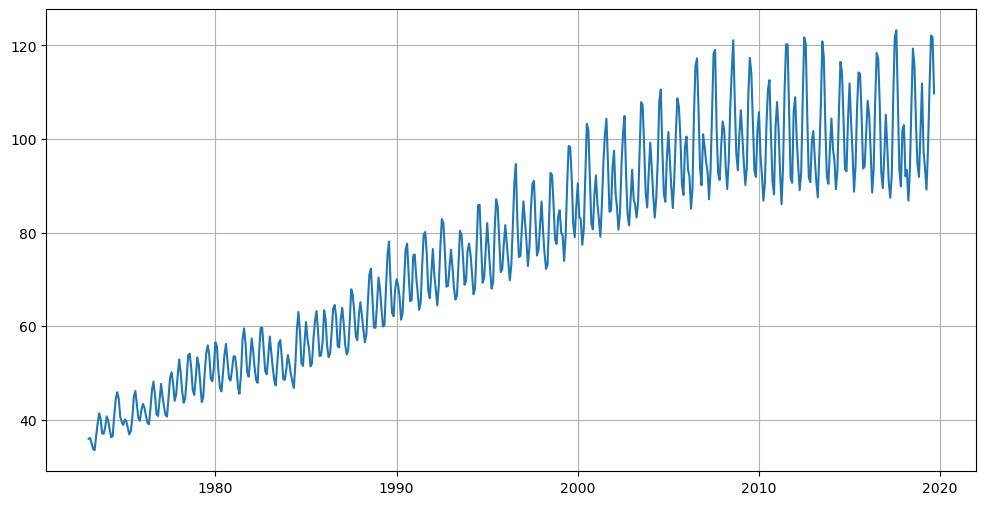

In [7]:
plt.figure(figsize=(12,6))
plt.plot(data.Consumption)
plt.grid()

### Checking for NULLS

In [8]:
data.isna().sum()

Consumption    0
Year           0
Month          0
dtype: int64

### Checking mean monthly usage

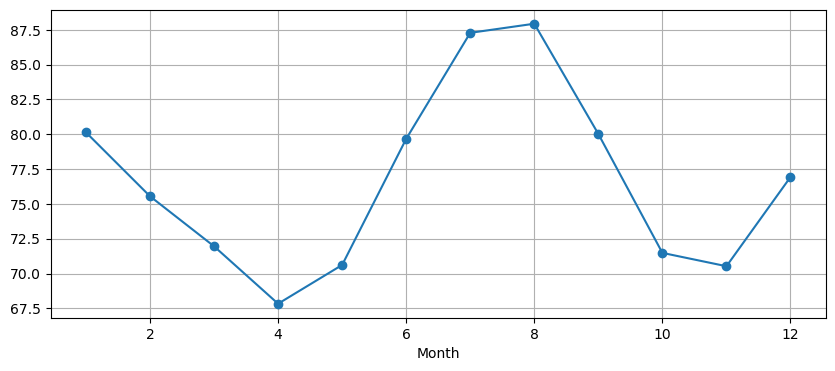

In [9]:
plt.figure(figsize=(10,4))
data.groupby(data.Month)['Consumption'].mean().plot(marker='o')
plt.grid()

### Checking Mean Yearly usage

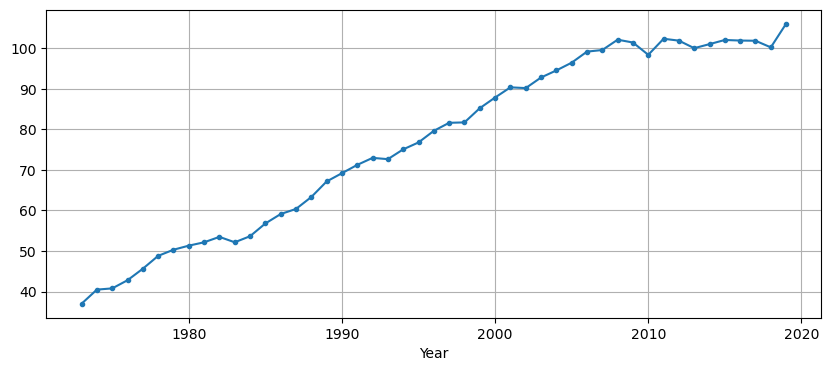

In [10]:
plt.figure(figsize=(10,4))
data.groupby(data.Year)['Consumption'].mean().plot(marker='.')
plt.grid()

### Checking Month-wise Yearly usage

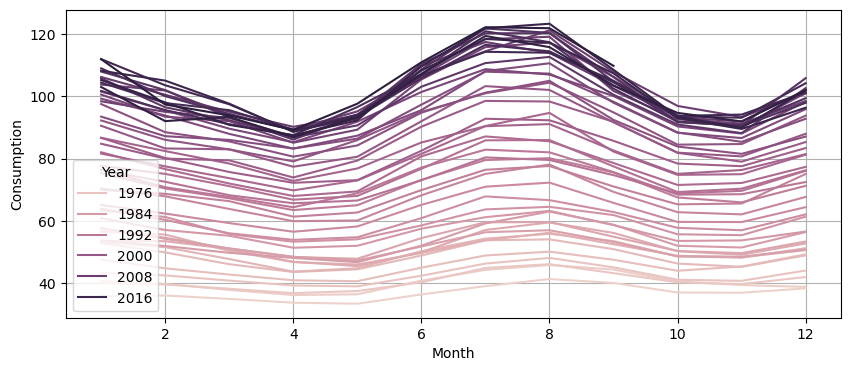

In [11]:
plt.figure(figsize=(10,4))
sns.lineplot(x=data.Month, y=data.Consumption, hue=data.Year)
plt.grid()
plt.show()

# Time Series Analysis

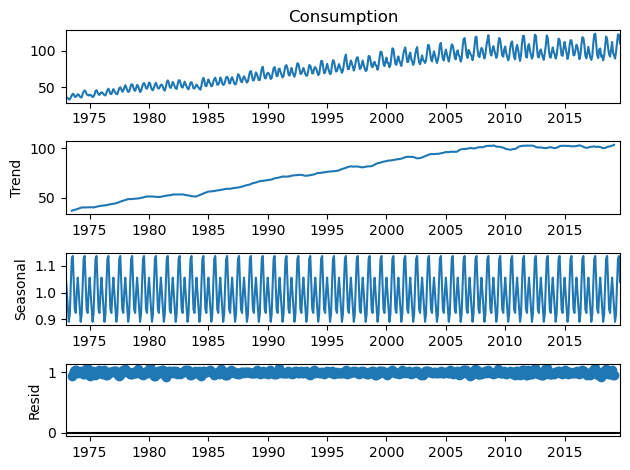

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data.Consumption, model='multiplicative')

result.plot()
plt.show()

## Check for Stationarity and Stationarizing

**'Ho'** - Time-Series data is Non-Stationary

**'Ha'** - Time-Series data is Stationary

**Significance Level** - 5%

In [9]:
from statsmodels.tsa.stattools import adfuller

adfuller(data.Consumption)

(-1.7405933729832501,
 0.410328160446865,
 15,
 545,
 {'1%': -3.442405720052601,
  '5%': -2.866857804790472,
  '10%': -2.5696022094099824},
 2295.409663118043)

In [10]:
def get_adfuller(ts):
    result = pd.Series(adfuller(ts)[0:4], index=['Test-Statistic','p-Value','Lags_Used','Samples'])
    return result

def check_stationarity(ts):
    adf_result = get_adfuller(ts)
    
    if adf_result['p-Value'] > 0.05:
        return f'Since p-Value: {adf_result["p-Value"]:.4f} > 0.05, data is Non-Stationary'
    else:
        return f'Since p-Value: {adf_result["p-Value"]:.4f} < 0.05, data is Stationary'

#### Checking Stationarity of original dataset

In [11]:
print(get_adfuller(data.Consumption))
check_stationarity(data.Consumption)

Test-Statistic     -1.740593
p-Value             0.410328
Lags_Used          15.000000
Samples           545.000000
dtype: float64


'Since p-Value: 0.4103 > 0.05, data is Non-Stationary'

#### Checking Stationarity of differenced data (1st order difference)

In [12]:
print(get_adfuller(data['Consumption'].diff().dropna()))
check_stationarity(data.Consumption.diff().dropna())

Test-Statistic   -7.941665e+00
p-Value           3.301344e-12
Lags_Used         1.400000e+01
Samples           5.450000e+02
dtype: float64


'Since p-Value: 0.0000 < 0.05, data is Stationary'

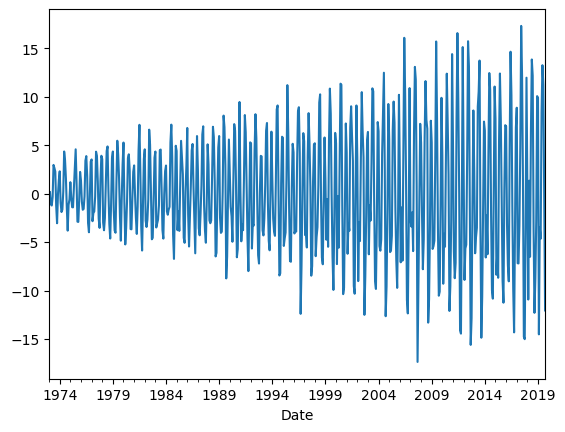

In [14]:
data['Consumption'].diff().plot()
plt.show()

#### Understanding auto-correlation structure of data

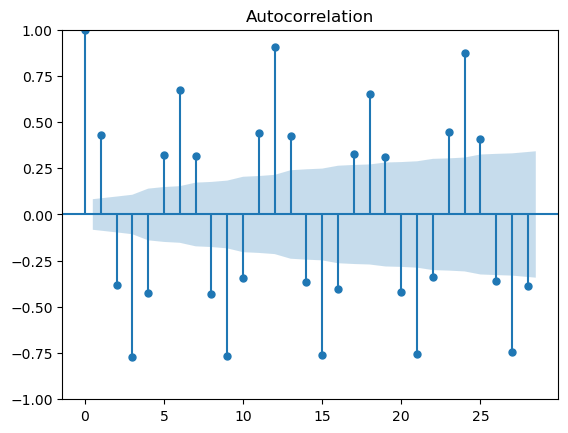

C:\Users\singh\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


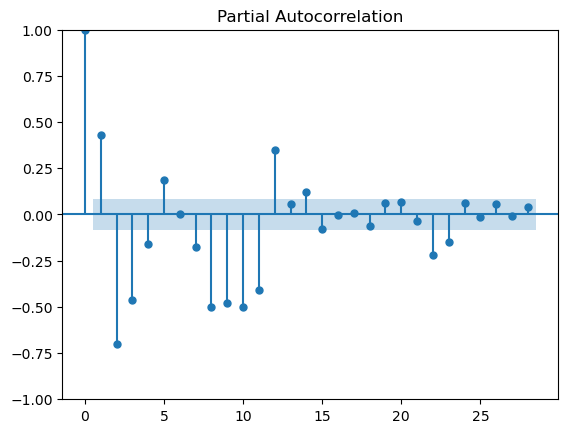

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data.Consumption.diff().dropna())
plt.show()
plot_pacf(data.Consumption.diff().dropna())
plt.show()

In [18]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
train, test = data.Consumption[:448], data.Consumption[448:]

model = ARIMA(endog=data.Consumption, order=(1,1,1))
model_fit = model.fit()
forecast = model_fit.forecast(steps = len(test))
#arima_pred = model_fit.predict(steps = len(test))
forecast

2019-10-01    103.008353
2019-11-01    101.996166
2019-12-01    101.843494
2020-01-01    101.820466
2020-02-01    101.816993
                 ...    
2028-10-01    101.816376
2028-11-01    101.816376
2028-12-01    101.816376
2029-01-01    101.816376
2029-02-01    101.816376
Freq: MS, Name: predicted_mean, Length: 113, dtype: float64

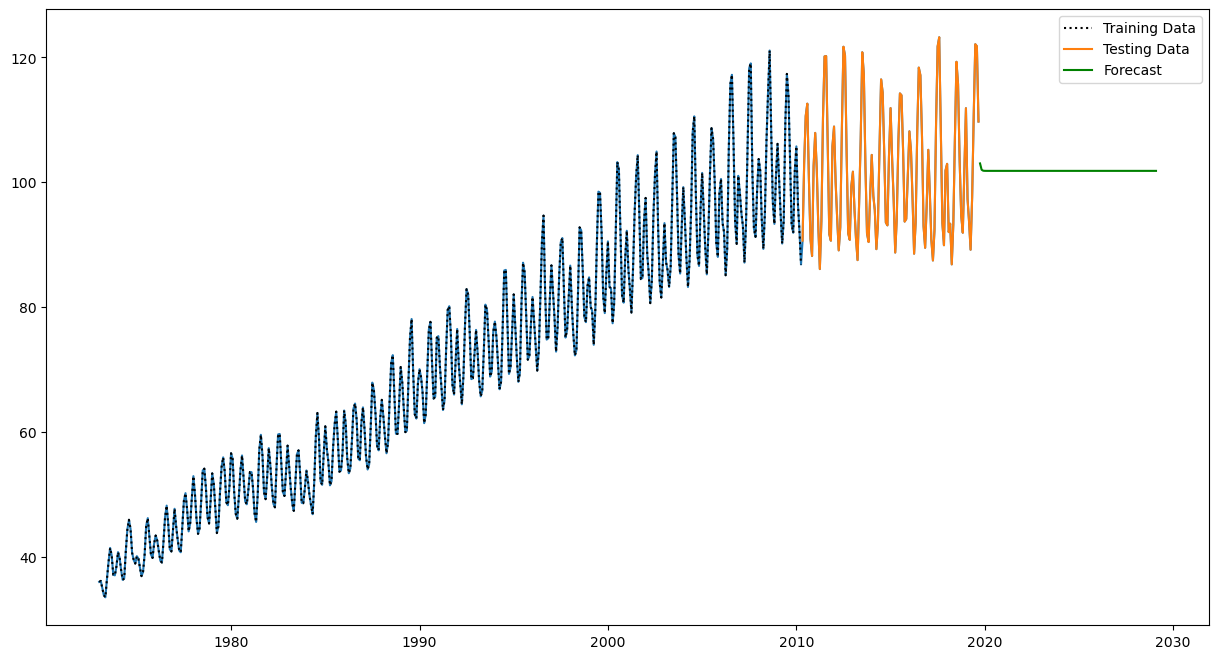

In [21]:
plt.figure(figsize=(15,8))
plt.plot(data.Consumption)
plt.plot(train, ls = ':', c='k', label='Training Data')
plt.plot(test, label='Testing Data')
plt.plot(forecast, c='g', label='Forecast')
plt.legend()
plt.show()

**Findings from above**
****
as data has seasonality ARIMA model won't work

In [22]:
order_list = []
mae_list = []
mape_list = []
for p in range(1,4):
    for d in range(1,4):
        for q in range(1,4):
            order = (p,d,q)
            model = ARIMA(endog=data.Consumption, order=order)
            model_fit = model.fit()
            forecast = model_fit.forecast(steps= test.shape[0])
            
            mae = mean_absolute_error(forecast,test)
            mape = mean_absolute_percentage_error(forecast,test)
            order_list.append(order)
            mae_list.append(mae)
            mape_list.append(mape)

In [23]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
df = pd.DataFrame({'order':order_list, 'mae':mae_list, 'mape':mape_list})
df.mape = df.mape*100
df.sort_values(by=['mae','mape'])

,order,mae,mape
0,"(1, 1, 1)",8.642687,8.487220
2,"(1, 1, 3)",8.791279,8.519422
1,"(1, 1, 2)",8.854417,8.540983
5,"(1, 2, 3)",9.260556,8.840992
9,"(2, 1, 1)",9.405160,9.015994
13,"(2, 2, 2)",9.532591,9.128239
3,"(1, 2, 1)",10.013830,9.331694
4,"(1, 2, 2)",10.731872,9.853919
18,"(3, 1, 1)",11.098632,10.118458
20,"(3, 1, 3)",11.583863,10.253890


In [24]:
order = (1,1,1)
seasonal_order = (1,1,1,12)

model = SARIMAX(train, order = order, seasonal_order=seasonal_order)
model_fit = model.fit()
preds = model_fit.forecast(steps = len(test))

mean_absolute_error(preds,test), train.mean()

(4.067518584824886, 70.38349709821429)

In [31]:
import warnings

warnings.filterwarnings('ignore')

In [27]:
## THIS CODE WILL TAKE A LOT OF TIME. THE INTENDED OUTCOME IS PRESENTED IN NEXT CELL

order_list = []
season_list = []
mae_list = []
mape_list = []
for p in range(1,3):
    for d in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for D in range(1,3):
                    for Q in range(1,3):
                        order = (p,d,q)
                        seasonal_order = (P,D,Q,12)
                        model = SARIMAX(train, order = order, seasonal_order=seasonal_order)
                        model_fit = model.fit()
                        forecast = model_fit.forecast(steps = len(test))

                        mae = mean_absolute_error(forecast,test)
                        mape = mean_absolute_percentage_error(forecast,test)
                        order_list.append(order)
                        season_list.append(seasonal_order)
                        mae_list.append(mae)
                        mape_list.append(mape)

In [28]:
df = pd.DataFrame({'order':order_list, 'season':season_list,'mae':mae_list, 'mape':mape_list})
df.mape = df.mape*100
df.sort_values(by=['mae','mape']).head(1)

,order,season,mae,mape
23,"(1, 2, 1)","(2, 2, 2, 12)",2.22946,2.157852


In [29]:
import pandas as pd
from itertools import product

# Define the parameter ranges
p_range = range(1, 3)
d_range = range(1, 3)
q_range = range(1, 3)
P_range = range(1, 3)
D_range = range(1, 3)
Q_range = range(1, 3)

# Generate all combinations of parameters
param_combinations = product(p_range, d_range, q_range, P_range, D_range, Q_range)

# Perform model fitting and evaluation for each combination
results = []
for p, d, q, P, D, Q in param_combinations:
    order = (p, d, q)
    seasonal_order = (P, D, Q, 12)
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))

    mae = mean_absolute_error(forecast, test)
    mape = mean_absolute_percentage_error(forecast, test)

    results.append((order, seasonal_order, mae, mape))

# Unpacking the results
order_list, season_list, mae_list, mape_list = zip(*results)

# Create a DataFrame from the results
df = pd.DataFrame({'order': order_list, 'season': season_list, 'mae': mae_list, 'mape': mape_list})

# Convert MAPE to percentage
df.mape = df.mape * 100

best_combination = df.sort_values(by=['mae', 'mape']).head(1)

print(best_combination)

        order         season      mae      mape
23  (1, 2, 1)  (2, 2, 2, 12)  2.22946  2.157852


In [30]:
order = (1,2,1)
seasonal_order = (2,2,2,12)

model = SARIMAX(train, order = order, seasonal_order=seasonal_order)
model_fit = model.fit()
preds = model_fit.forecast(steps = len(test))

mean_absolute_error(preds,test), train.mean()

(2.229459873330617, 70.38349709821429)

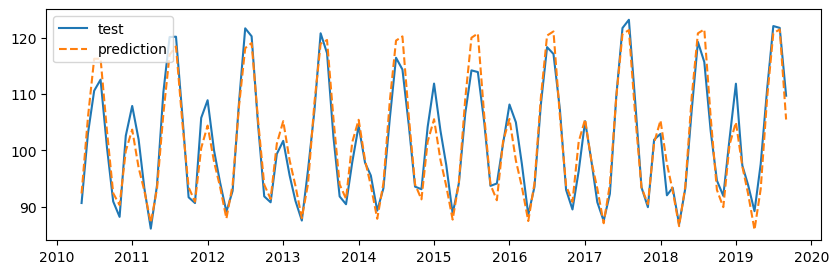

In [31]:
plt.figure(figsize=(10,3))
plt.plot(test, label = 'test')
plt.plot(preds, label = 'prediction', ls='--')
#plt.plot(arima_pred, label='arima_pred')
plt.legend()
plt.show()

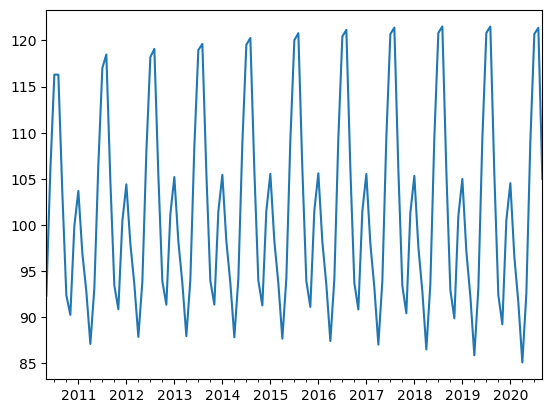

In [32]:
model_fit.forecast(steps=len(test) + 12).plot()
plt.show()

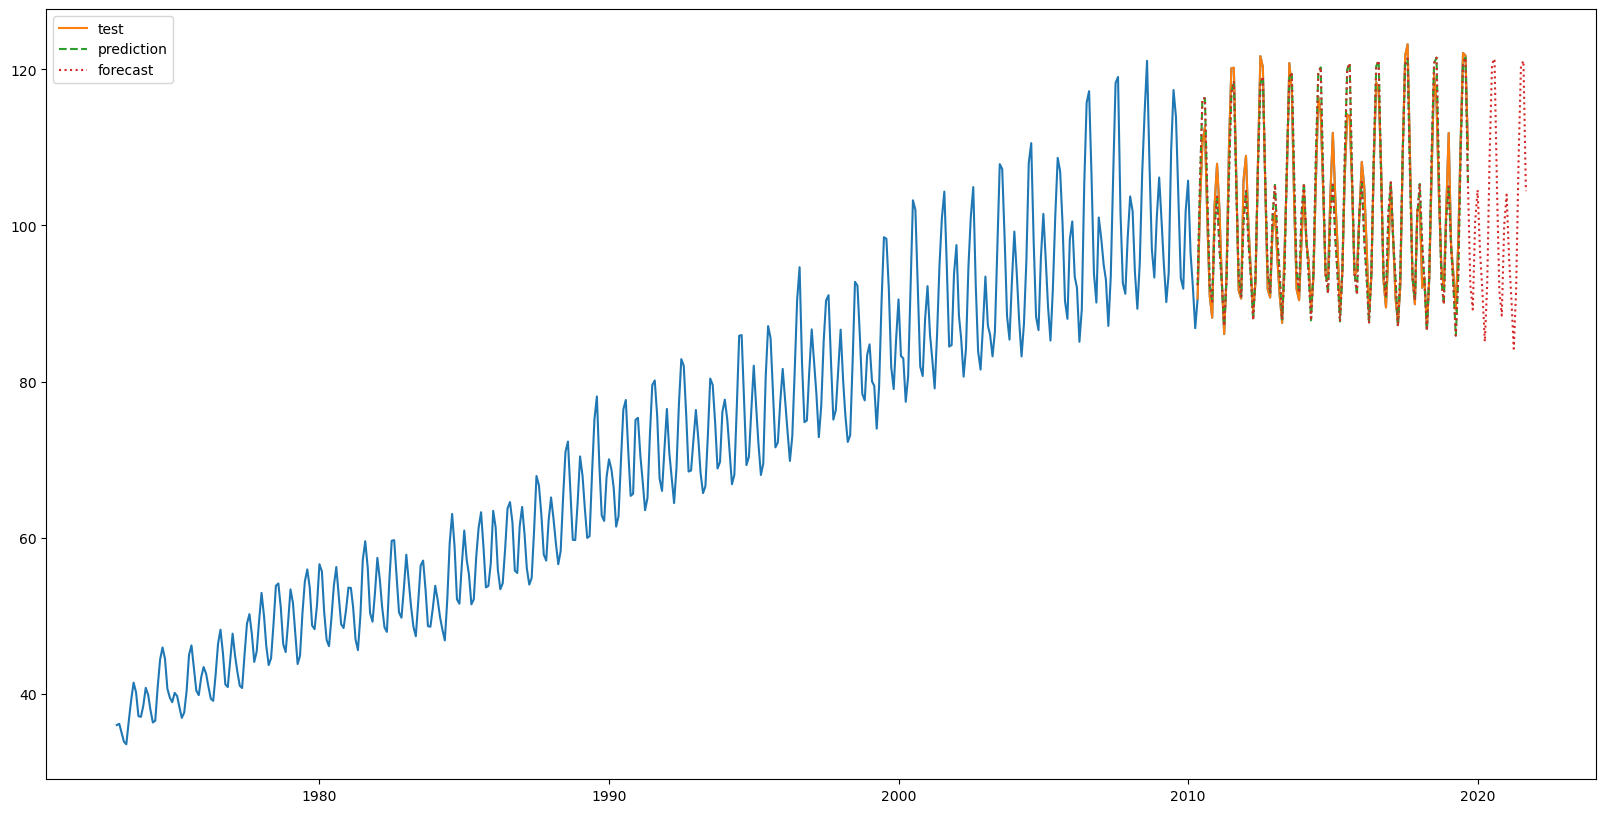

In [33]:
plt.figure(figsize=(20,10))
plt.plot(data.Consumption)
plt.plot(test, label = 'test')
plt.plot(preds, label = 'prediction', ls='--')
plt.plot(model_fit.forecast(steps=len(test) + 24), label='forecast', ls=':')
#plt.plot(arima_pred, label='arima_pred')
plt.legend()
plt.show()

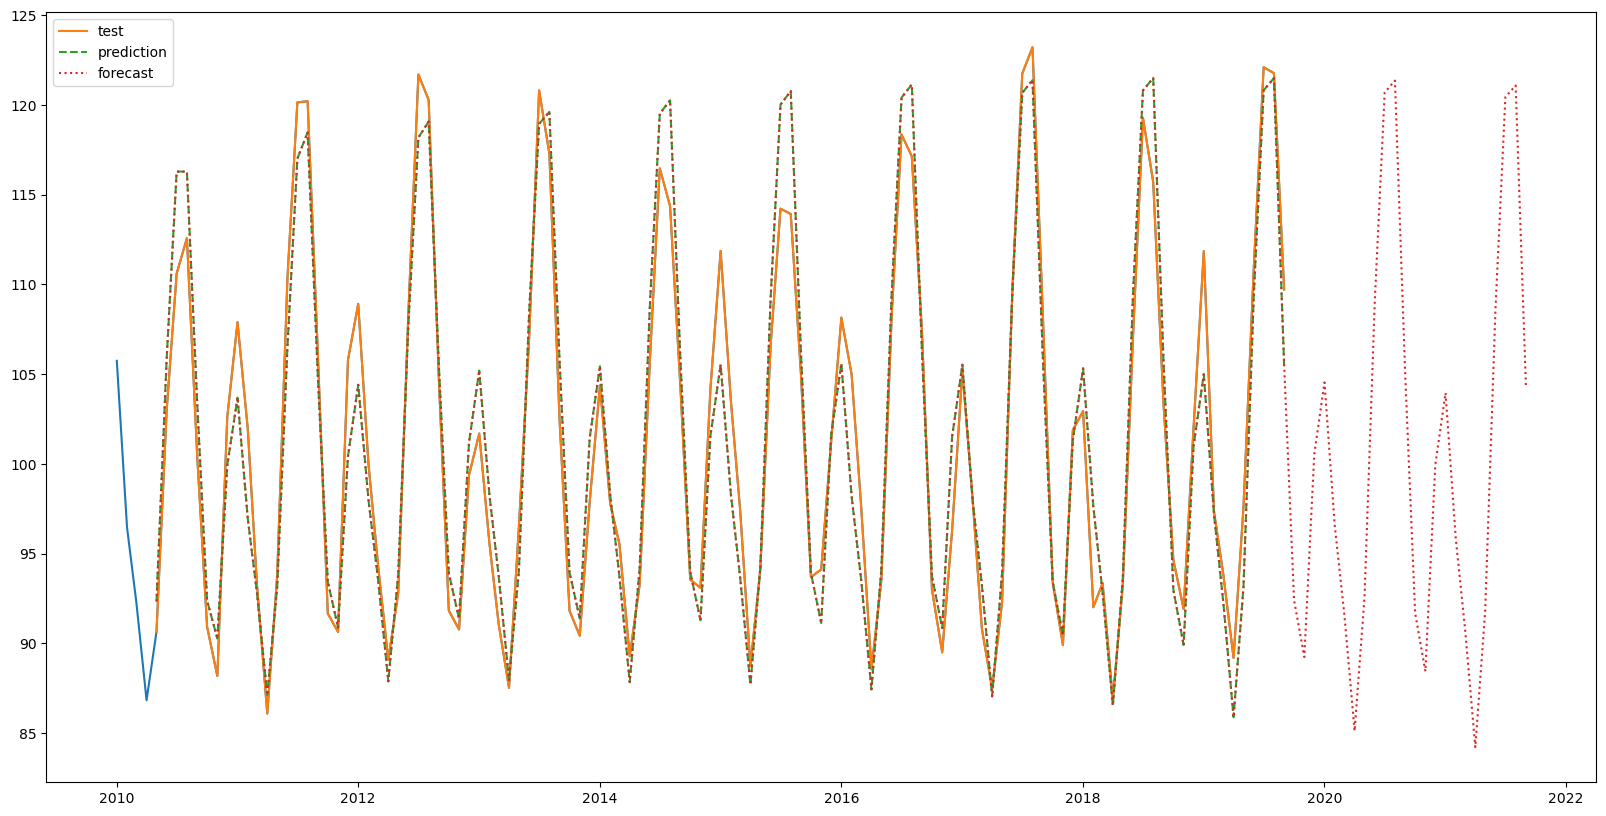

In [34]:
plt.figure(figsize=(20,10))
plt.plot(data.Consumption.loc['2010-01-01':])
plt.plot(test, label = 'test')
plt.plot(preds, label = 'prediction', ls='--')
plt.plot(model_fit.forecast(steps=len(test) + 24), label='forecast', ls=':')
#plt.plot(arima_pred, label='arima_pred')
plt.legend()
plt.show()